# Albumentations Modeling Notebook

In [24]:
# # Install the plaidml backend
# ## DO THIS BEFORE IMPORTING KERAS OR TENSOR TO USE PLAIDML
# import plaidml.keras
# plaidml.keras.install_backend()

# # Help MacOS be able to use Keras
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# # Gets rid of the processor warning.
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [25]:
# ## Use this as callback on .fit (callbacks=[cb])
# ## NOT necessary

# # better progress bars for jupyter and won't kill model fit
# # Command line the following line to get tqdm installed properly
# # python -m pip install tqdm
# from keras_tqdm import TQDMNotebookCallback
# # keras, model definition...
# cb = TQDMNotebookCallback()
# setattr(cb,'on_train_batch_begin',lambda x,y:None)
# setattr(cb,'on_train_batch_end',lambda x,y:None)



## Importing Packages

In [40]:
# from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


## Augmentation through ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
model = create_model((224, 224, 3))
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [82]:
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator)

## Augmentation through Albumentations

In [88]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 3830 images belonging to 2 classes.
Found 767 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [89]:
X_tr, y_tr = next(train_generator)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(test_generator)

## CNN Model

This model was inspired by the VGG16 model which was the only one that seemed to produce any normal metrics

In [90]:
model2 = create_model((256, 256, 3))
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr=0.001),
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [14]:
filepath = '../models/CNN.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
history2 = model2.fit(train_generator,
                                epochs = 20,
                                callbacks = [earlyStopping, mcp_save],
                                validation_data = val_generator)

Epoch 1/20
120/120 [==============================] - 2901s 24s/step - loss: 102.6561 - accuracy: 0.7186 - auc_2: 0.7197 - auc_3: 0.7999 - precision_1: 0.7871 - recall_1: 0.7884 - val_loss: 2.7091 - val_accuracy: 0.9086 - val_auc_2: 0.5605 - val_auc_3: 0.9637 - val_precision_1: 0.9637 - val_recall_1: 0.9400
Epoch 2/20
120/120 [==============================] - 1801s 15s/step - loss: 0.7821 - accuracy: 0.8220 - auc_2: 0.8534 - auc_3: 0.9090 - precision_1: 0.8198 - recall_1: 0.9425 - val_loss: 0.8175 - val_accuracy: 0.9189 - val_auc_2: 0.6906 - val_auc_3: 0.9769 - val_precision_1: 0.9598 - val_recall_1: 0.9554
Epoch 3/20
120/120 [==============================] - 1788s 15s/step - loss: 0.4969 - accuracy: 0.8447 - auc_2: 0.8781 - auc_3: 0.9282 - precision_1: 0.8195 - recall_1: 0.9866 - val_loss: 53.7068 - val_accuracy: 0.9307 - val_auc_2: 0.4846 - val_auc_3: 0.9575 - val_precision_1: 0.9575 - val_recall_1: 0.9708
Epoch 4/20
120/120 [==============================] - 1909s 16s/step - loss:

In [35]:
model3 = create_model((224, 224, 3))
model3.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr=0.001),
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [36]:
filepath = '../models/CNN3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [earlyStopping, mcp_save],
                     validation_data = val_generator,
                     batch_size=16)

Epoch 1/20
240/240 [==============================] - 3491s 14s/step - loss: 10.5405 - accuracy: 0.7179 - auc_6: 0.7226 - auc_7: 0.8007 - precision_3: 0.7980 - recall_3: 0.7778 - val_loss: 12.2931 - val_accuracy: 0.9513 - val_auc_6: 0.5280 - val_auc_7: 0.9609 - val_precision_3: 0.9598 - val_recall_3: 0.9908
Epoch 2/20
240/240 [==============================] - 2231s 9s/step - loss: 0.8515 - accuracy: 0.8071 - auc_6: 0.8212 - auc_7: 0.8639 - precision_3: 0.8346 - recall_3: 0.8925 - val_loss: 0.2241 - val_accuracy: 0.9587 - val_auc_6: 0.7116 - val_auc_7: 0.9801 - val_precision_3: 0.9587 - val_recall_3: 1.0000
Epoch 3/20
240/240 [==============================] - 2001s 8s/step - loss: 0.4219 - accuracy: 0.8271 - auc_6: 0.8671 - auc_7: 0.9174 - precision_3: 0.8302 - recall_3: 0.9376 - val_loss: 0.3161 - val_accuracy: 0.8687 - val_auc_6: 0.6320 - val_auc_7: 0.9757 - val_precision_3: 0.9591 - val_recall_3: 0.9015
Epoch 4/20
240/240 [==============================] - 1992s 8s/step - loss: 0.3

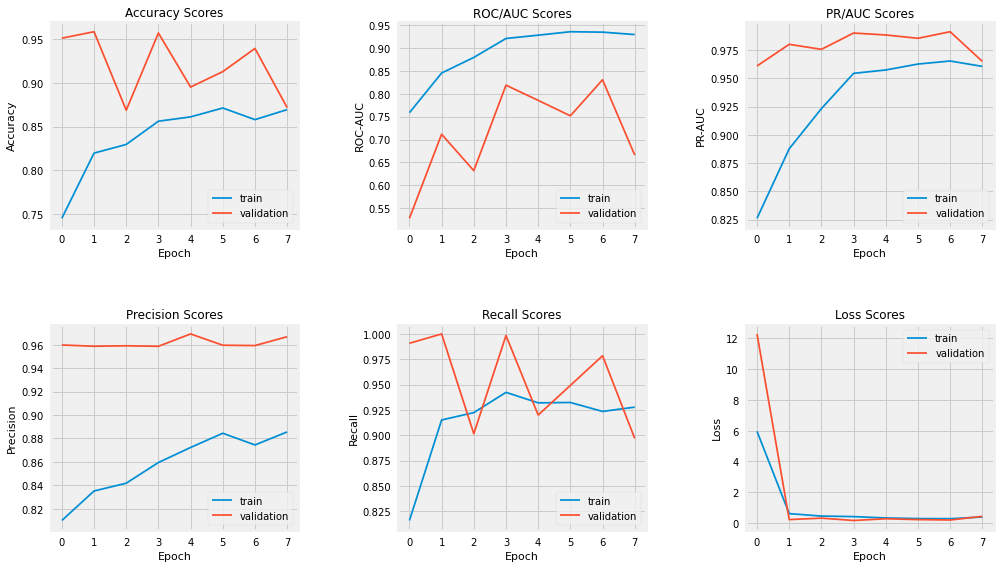

In [44]:
plt.style.use('seaborn-notebook')
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

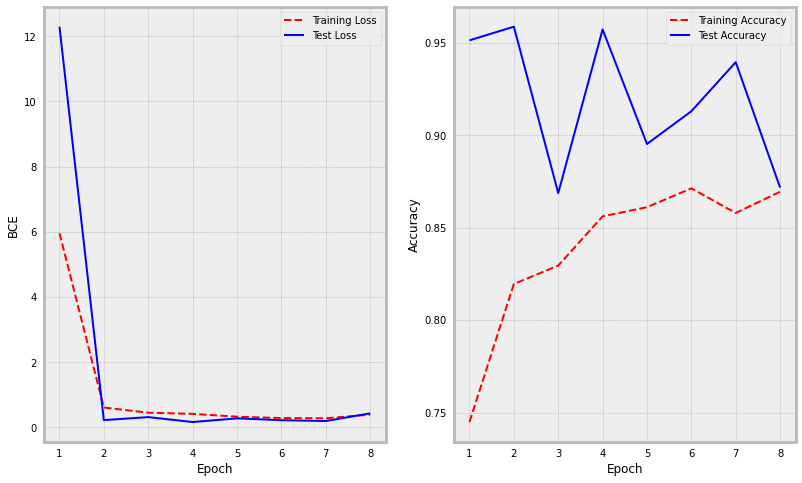

In [47]:
plt.style.use('bmh')
graph_loss(history3)

In [48]:
hist_df_2 = pd.DataFrame(history3.history)
hist_df_2

,loss,accuracy,auc_6,auc_7,precision_3,recall_3,val_loss,val_accuracy,val_auc_6,val_auc_7,val_precision_3,val_recall_3
0,5.959352,0.744909,0.758642,0.826092,0.810069,0.815982,12.293129,0.951327,0.527995,0.960942,0.959762,0.990769
1,0.610057,0.819582,0.845289,0.887599,0.835203,0.915098,0.224131,0.958702,0.711566,0.980095,0.958702,1.000000
2,0.451655,0.829504,0.879377,0.923176,0.841865,0.922397,0.316067,0.868732,0.631978,0.975656,0.959083,0.901538
3,0.416313,0.856136,0.920728,0.954409,0.859495,0.942374,0.165416,0.957227,0.818736,0.990093,0.958641,0.998462
4,0.328959,0.861097,0.927976,0.957397,0.872348,0.932002,0.277417,0.895280,0.785549,0.988379,0.969206,0.920000
5,0.287642,0.871279,0.935500,0.962636,0.884475,0.932386,0.222067,0.912979,0.751758,0.985440,0.959565,0.949231
6,0.280256,0.857963,0.934572,0.965333,0.874500,0.923550,0.195969,0.939528,0.830494,0.991259,0.959276,0.978462
7,0.392078,0.869452,0.929319,0.960551,0.885589,0.927776,0.431595,0.871681,0.666017,0.964980,0.966833,0.896923


# VGG16

In [39]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False
input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model4 = Model(inputs=input_, outputs=last_layer)
model4.compile(optimizer = Adam(lr=0.01), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [41]:
filepath = '../models/CNN_v3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
history4 = model4.fit(train_generator,
                     epochs = 20,
                     callbacks = [earlyStopping, mcp_save],
                     validation_data = val_generator)

Epoch 1/20
14/14 [==============================] - 214s 16s/step - loss: 2.3746 - accuracy: 0.6548 - precision_3: 0.7153 - recall_3: 0.6959 - auc_6: 0.6812 - auc_7: 0.7649 - val_loss: 0.8371 - val_accuracy: 0.8776 - val_precision_3: 0.9595 - val_recall_3: 0.9108 - val_auc_6: 0.5680 - val_auc_7: 0.9649
Epoch 2/20
14/14 [==============================] - 231s 17s/step - loss: 0.5604 - accuracy: 0.8936 - precision_3: 0.9168 - recall_3: 0.9287 - auc_6: 0.9074 - auc_7: 0.9332 - val_loss: 0.8084 - val_accuracy: 0.8805 - val_precision_3: 0.9656 - val_recall_3: 0.9077 - val_auc_6: 0.6675 - val_auc_7: 0.9746
Epoch 3/20
14/14 [==============================] - 215s 16s/step - loss: 0.7909 - accuracy: 0.8567 - precision_3: 0.9037 - recall_3: 0.8882 - auc_6: 0.8953 - auc_7: 0.9285 - val_loss: 1.1012 - val_accuracy: 0.7817 - val_precision_3: 0.9736 - val_recall_3: 0.7938 - val_auc_6: 0.7539 - val_auc_7: 0.9849
Epoch 4/20
14/14 [==============================] - 232s 17s/step - loss: 0.5411 - accur

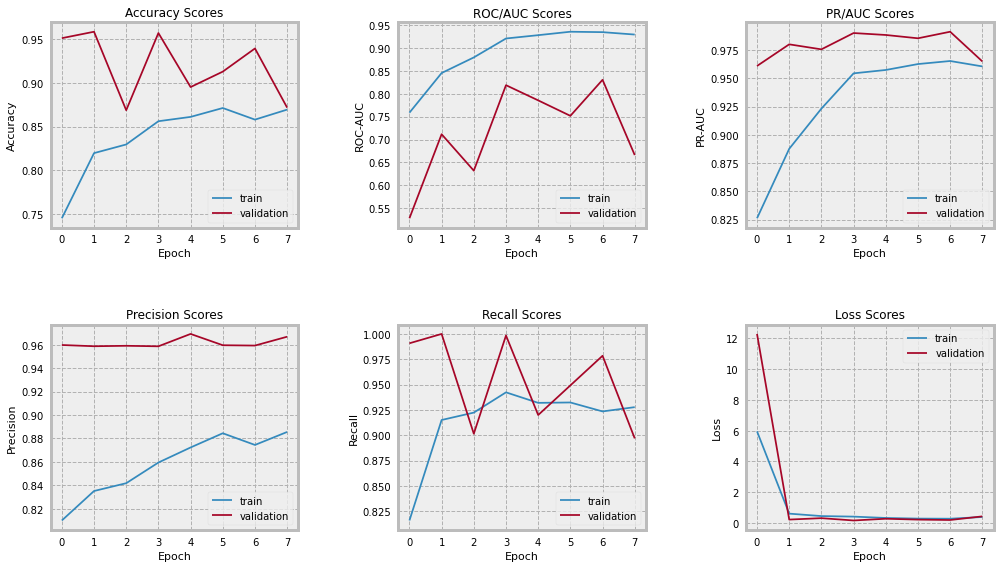

In [60]:
plt.style.use('seaborn-notebook')
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

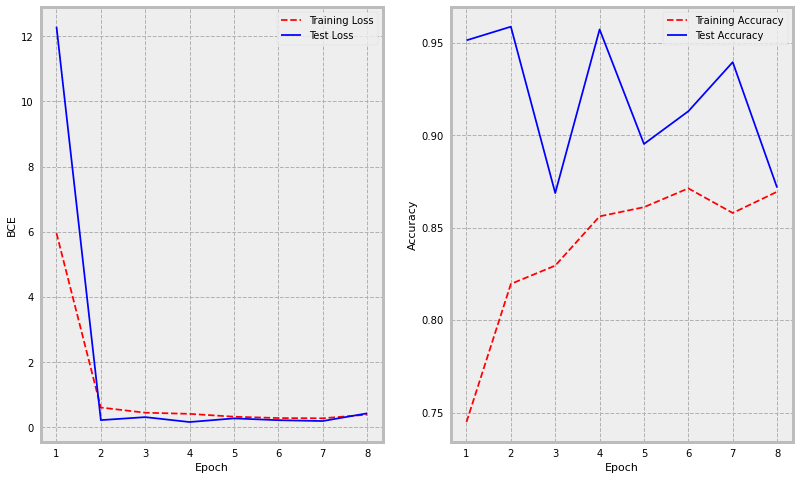

In [56]:
graph_loss(history3)

In [57]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc_6,auc_7,precision_3,recall_3,val_loss,val_accuracy,val_auc_6,val_auc_7,val_precision_3,val_recall_3
0,5.959352,0.744909,0.758642,0.826092,0.810069,0.815982,12.293129,0.951327,0.527995,0.960942,0.959762,0.990769
1,0.610057,0.819582,0.845289,0.887599,0.835203,0.915098,0.224131,0.958702,0.711566,0.980095,0.958702,1.000000
2,0.451655,0.829504,0.879377,0.923176,0.841865,0.922397,0.316067,0.868732,0.631978,0.975656,0.959083,0.901538
3,0.416313,0.856136,0.920728,0.954409,0.859495,0.942374,0.165416,0.957227,0.818736,0.990093,0.958641,0.998462
4,0.328959,0.861097,0.927976,0.957397,0.872348,0.932002,0.277417,0.895280,0.785549,0.988379,0.969206,0.920000
5,0.287642,0.871279,0.935500,0.962636,0.884475,0.932386,0.222067,0.912979,0.751758,0.985440,0.959565,0.949231
6,0.280256,0.857963,0.934572,0.965333,0.874500,0.923550,0.195969,0.939528,0.830494,0.991259,0.959276,0.978462
7,0.392078,0.869452,0.929319,0.960551,0.885589,0.927776,0.431595,0.871681,0.666017,0.964980,0.966833,0.896923


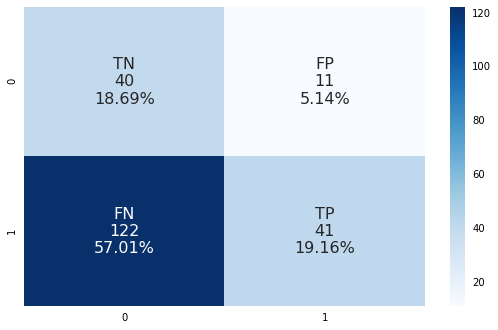

In [58]:
prob = model3.predict_generator(test_generator)
y_true = test_generator.classes
y_pred3 = prob > 0.5
make_confusion_matrix(y_true, y_pred3)

# CNN Model

In [78]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 3830 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [79]:
def cnn(input_shape):
    return Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2), 
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.25),     
        Dense(units=1, activation='sigmoid')
        ])

model5 = cnn((256, 256, 3))
model5.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])


In [81]:
filepath = '../models/CNN_v5.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')
history5 = model5.fit(train_generator,
                     epochs = 20,
                     callbacks = [earlyStopping, mcp_save],
                     validation_data = val_generator)

Epoch 1/20
240/240 [==============================] - 742s 3s/step - loss: 0.6053 - accuracy: 0.7802 - auc_16: 0.7568 - auc_17: 0.8304 - precision_8: 0.7688 - recall_8: 0.9531 - val_loss: 0.5274 - val_accuracy: 0.9558 - val_auc_16: 0.7746 - val_auc_17: 0.9861 - val_precision_8: 0.9586 - val_recall_8: 0.9969
Epoch 2/20
240/240 [==============================] - 813s 3s/step - loss: 0.3557 - accuracy: 0.8505 - auc_16: 0.8694 - auc_17: 0.9177 - precision_8: 0.8284 - recall_8: 0.9847 - val_loss: 0.4043 - val_accuracy: 0.8746 - val_auc_16: 0.8277 - val_auc_17: 0.9912 - val_precision_8: 0.9748 - val_recall_8: 0.8923
Epoch 3/20
240/240 [==============================] - 1148s 5s/step - loss: 0.2546 - accuracy: 0.8960 - auc_16: 0.9439 - auc_17: 0.9672 - precision_8: 0.8998 - recall_8: 0.9557 - val_loss: 0.5807 - val_accuracy: 0.8702 - val_auc_16: 0.7530 - val_auc_17: 0.9847 - val_precision_8: 0.9731 - val_recall_8: 0.8892
Epoch 4/20
240/240 [==============================] - 1046s 4s/step - lo

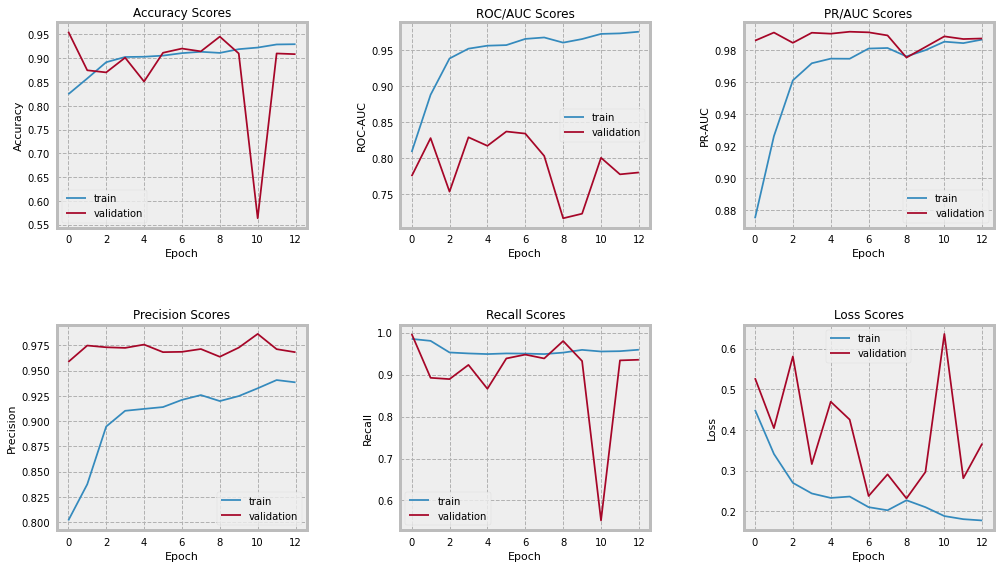

In [83]:
plt.style.use('seaborn-notebook')
sixplot(history5, 'auc_16', 'val_auc_16', 'auc_17', 'val_auc_17', 'precision_8', 'val_precision_8', 'recall_8', 'val_recall_8')

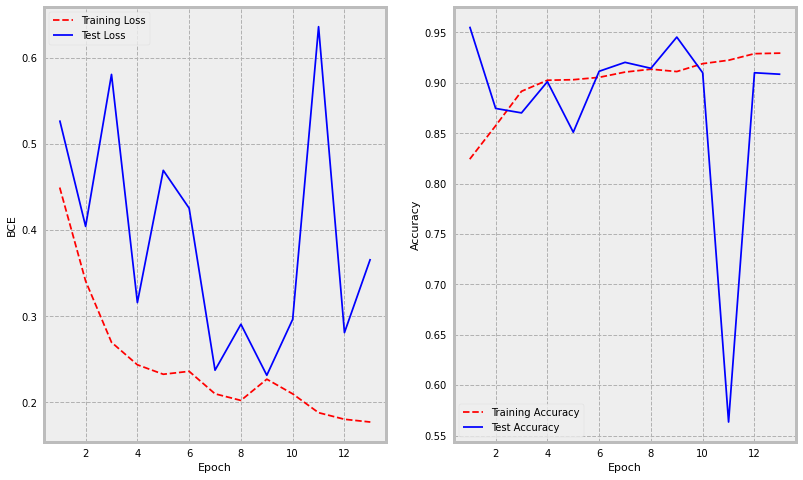

In [85]:
graph_loss(history5)

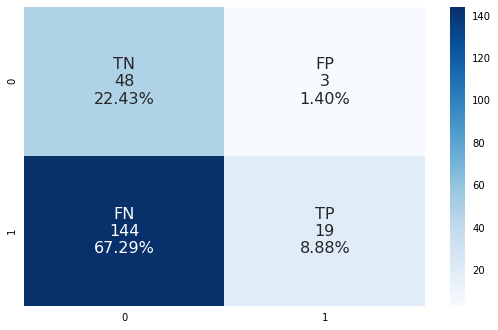

In [86]:
prob = model5.predict_generator(test_generator)
y_true = test_generator.classes
y_pred5 = prob > 0.5
make_confusion_matrix(y_true, y_pred5)